<a href="https://colab.research.google.com/gist/wfhsu3/739d0dbea93bea536c37964985f3ab2f/__main__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()

import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

True

In [17]:
#@title Initializing environment
import os
import cv2
import glob
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Model, Sequential
from keras.layers import BatchNormalization, Activation, Dropout,Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D 
from keras.applications.vgg16 import VGG16, preprocess_input

# Read input images and assign labels based on folder names
os.chdir("/content/drive/MyDrive/Colab Notebooks/mtImage/train/")
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/mtImage/train/"))

['normal', 'scar']


In [2]:
#@title Load image data and do preprocessing
#title Loading and preprocessing Training/Validation data
SIZE = 224  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/mtImage/train/*"):
    label = directory_path.split("/",7)[-1]
    
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

#==============================================================================
# Capture test/validation data and labels into respective lists
test_images = []
test_labels = [] 

for directory_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/mtImage/val/*"):
    label = directory_path.split("/",7)[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
print(np.unique(train_labels_encoded))

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


[0 1]


In [3]:
#@title Load VGG16 model and build customized model
#===============================================================================
#Load model wothout classifier/fully connected layers
from keras.applications.vgg16 import VGG16
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable (work with pre-trained weights)
for layer in VGG_model.layers:
	layer.trainable = False

model = Sequential()
for i in range(len(VGG_model.layers)-12):
    model.add(VGG_model.layers[i])

#model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))
model.summary()

# compile new model
import tensorflow as tf
model.compile(loss="binary_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=["accuracy"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 64)        7

In [4]:
#@title Load saved model and train
from keras.models import load_model
from pathlib import Path

path_to_file = '/content/drive/MyDrive/Colab Notebooks/mtImage/scar_model.h5'
path = Path(path_to_file)

retrain = 1

if path.is_file():
  if retrain ==0:
    model = load_model(path_to_file)

  else:
     model = load_model(path_to_file)
     history = model.fit(x_train, y_train, verbose=1, epochs=1, batch_size=10,
                    validation_data=(x_test, y_test))   
else:
   history = model.fit(x_train, y_train, verbose=1, epochs=100, batch_size=10,
                    validation_data=(x_test, y_test))
  
model.save('/content/drive/MyDrive/Colab Notebooks/mtImage/scar_model.h5')
#results = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', results[0])
#print('Test accuracy:', results[1])

68/68 [==============================] - 7s 50ms/step - loss: 0.1994 - accuracy: 0.9114 - val_loss: 0.1498 - val_accuracy: 0.9588


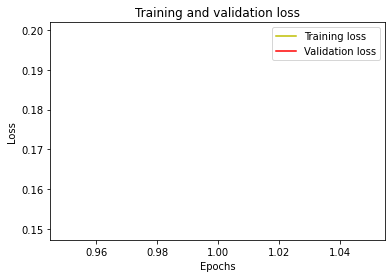

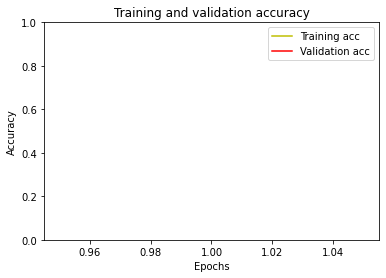

6/6 [==============================] - 2s 66ms/step


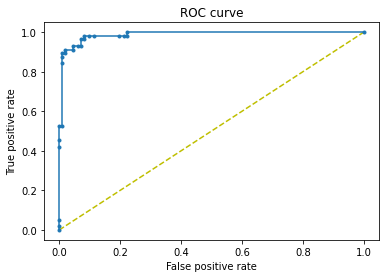

Ideal threshold is:  0.32760563492774963
Area under curve, AUC =  0.9878900791802515
6/6 [==============================] - 0s 77ms/step


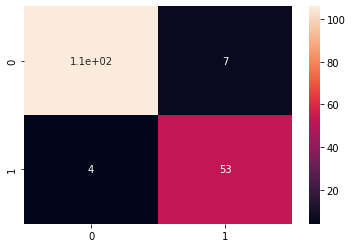

In [5]:
#@title Characterizing model performance 
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']  #Use accuracy if acc doesn't work
val_acc = history.history['val_accuracy']  #Use val_accuracy if acc doesn't work
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.ylim(0,1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(x_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

"""
#One way to find the best threshold once we calculate the true positive 
and false positive rates is ...
The optimal cut off point would be where “true positive rate” is high 
and the “false positive rate” is low. 
Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
"""
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
ideal_roc_thresh_val = float(ideal_roc_thresh['thresholds'])
print("Ideal threshold is: ", ideal_roc_thresh_val) 

#Now use this threshold value in the confusion matrix to visualize the balance
#between tp, fp, fp, and fn

#AUC
#Area under the curve (AUC) for ROC plot can be used to understand hpw well a classifier 
#is performing. 
#% chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

# Plot Confusion-matrix / ROC curve
# Predicting the Test set results
y_pred = model.predict(x_test)
y_pred = (y_pred > ideal_roc_thresh_val)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

In [6]:
#@title Grad-Cam Visualization

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    
    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str

    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''
    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the image through 
      # the gradient model, and grab the loss associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
      
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them as weights,
		# compute the ponderation of the filters with respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize the output 
		# class activation map to match the input image dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

		# normalize the heatmap such that all values lie in the range [0, 1], 
		# scale the resulting values to the range [0, 255], and then convert
		# to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom

    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def visualize_heatmap(img_bgr, cam, thresh, emphasize=False, eps=1e-8):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    
    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)
    '''  
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
        heatmap = (heatmap* 255).astype("uint8")

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return heatmap 
  
# visualize last layer from grad-cam
def interpret_feature(img_bgr, img, layer_name):
  '''
  img: np.expand_dims(pred_img, axis=0)
  layer_name: layer to be visualized
  '''
  grad_cam=GradCam(model, img, layer_name)

  #threshloding grad_heatmap
  grad_cam_255 = img_as_ubyte(grad_cam)
  ret, thresh255 = cv2.threshold((grad_cam_255), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  
  grad_heatmap = visualize_heatmap(img_bgr, grad_cam, ret, emphasize=True)

  return grad_heatmap, ret

#"""Disk convolution
#from scipy import signal
#def disk_conv(img, radius):
#  filt = cv2.cvtColor (img, cv2.COLOR_RGB2GRAY)
#  print(filt)
#  r = radius
#  y, x =np.ogrid[-r:r+1,-r:r+1]
#  disk = x**2+y**2 <= r**2

#  disk = disk.astype(float)
#  blur = signal.convolve2d(filt, disk, mode='full', boundary='fill', fillvalue=0)
#  blur = blur* np.max(blur)/255
#  blur = cv2.resize(blur, (256,256))
#  #blur = blur/255.
#  #blur= (blur * 255).astype("uint8")

#  return blur
#"""

1/1 [==============================] - 0s 405ms/step
The probability of prediction is: [0.9536608]
The prediction for this image is:  ['scar']


<ipython-input-6-f269af90e343>:63: RuntimeWarning: overflow encountered in exp
  return c / (1 + np.exp(-a * (x-b)))


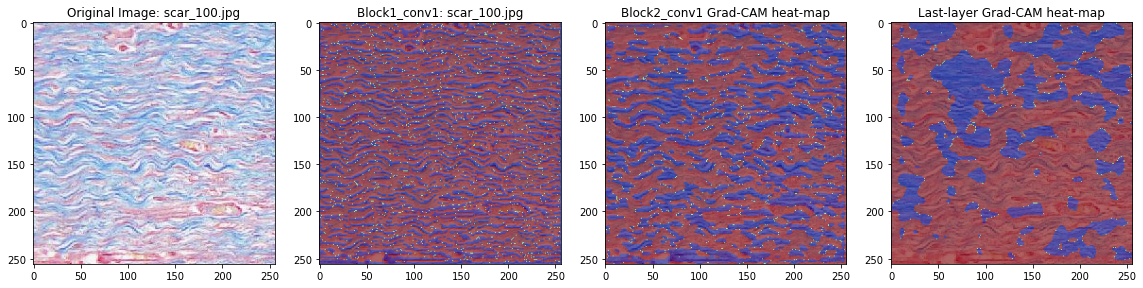

In [7]:
#@title Predicting new data & visualized by Grad-cam

import keras.utils as image
from keras.utils import load_img
from skimage.util import img_as_ubyte, img_as_float32

def processing_image(img_path, SIZE=224):
  
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
  img = cv2.resize(img, (SIZE, SIZE))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  x = np.array(img)
  x = x/255.0
 
  # Expand dims of imput from (224, 224, 3) to（1, 224, 224, 3) 
  #x = np.expand_dims(x, axis=0)
  
  return x

def decode_prediction(pred):
 
  # This function thresholds a probability to produce a prediction
  pred = tf.where(pred < ideal_roc_thresh_val, 0, 1)
 
  return pred.numpy()

#Predicting single image
img_path = '/content/drive/MyDrive/Colab Notebooks/mtImage/train/scar/scar_100.jpg'
original_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)

pred_img = processing_image(img_path)
pred_img = np.expand_dims(pred_img, axis=0)
pred_raw = model.predict(pred_img)[0] 
prediction = decode_prediction(pred_raw)
prediction = le.inverse_transform(prediction)  #Reverse the label encoder to original name

print("The probability of prediction is:", pred_raw)
print("The prediction for this image is: ", prediction)

feature_block1v1, ret2 = interpret_feature(original_img, pred_img, 'block1_conv1')
feature_block1v2, ret2 = interpret_feature(original_img, pred_img, 'block2_conv1')
feature_last, ret1 = interpret_feature(original_img, pred_img, 'conv2d')
"""
disk_conv_last = disk_conv(feature_last, 3)
disk_conv_block1v1 = disk_conv(feature_block1v1, 3)
"""

plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 4, 1)
plt.imshow(original_img, alpha=1)
#plt.axis('off')
plt.title('Original Image: '+str(img_path.split("/",8)[-1]))

ax = plt.subplot(1, 4, 2)
plt.imshow(feature_block1v1, alpha=1)
plt.imshow(original_img, alpha=0.4)

#plt.axis('off')
plt.title('Block1_conv1: '+str(img_path.split("/",8)[-1]))

ax = plt.subplot(1, 4, 3)
plt.imshow(feature_block1v2, alpha=1)
plt.imshow(original_img, alpha=0.4)

#plt.axis('off')
plt.title('Block2_conv1 Grad-CAM heat-map')

ax = plt.subplot(1, 4, 4)
plt.imshow(feature_last, alpha=1)
plt.imshow(original_img, alpha=0.4)
#im = imshow(original_img, alpha=0.4)
#plt.axis('off')
plt.title('Last-layer Grad-CAM heat-map')


plt.tight_layout()
plt.savefig(str(img_path.split("/",8)[-1]) + '_no emphasized.jpg')   


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________
1/1 [==============================] - 0s 38ms/step


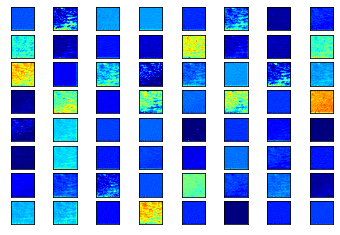

In [14]:
#@title Visualize features from block1_conv1
from numpy import expand_dims

# redefine model to output right after the first hidden layer
color_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
color_model.summary()

feature_maps = color_model.predict(pred_img) 
# get feature map for first hidden layer, and plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
 for _ in range(square):
 # specify subplot and turn of axis
  ax = plt.subplot(square, square, ix)
  ax.set_xticks([])
  ax.set_yticks([])
  #plot filter channel in grayscale
  plt.imshow(feature_maps[0, :, :, ix-1], cmap='jet')
  ix += 1
  
# show the figure
plt.show()

In [9]:
#@title Loop over train files for statistical analysis(opt.)
from skimage.util import img_as_ubyte, img_as_float32

#loop over file
feature_last_data=[]
feature_block1v1_data=[]
feature_block1v2_data=[]
n=0
thr=[]
test_directory_path ='/content/drive/MyDrive/Colab Notebooks/mtImage/testingData/by Treats - Copy/HA2_D60/*.jpg' 

for test_path in glob.glob(test_directory_path):

  original_img = cv2.imread(test_path, cv2.IMREAD_COLOR)
  original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
  
  pred_img = processing_image(test_path)
  pred_img = np.expand_dims(pred_img, axis=0)
  pred_raw = model.predict(pred_img)[0] 
  prediction = decode_prediction(pred_raw)
  prediction = le.inverse_transform(prediction)  #Reverse the label encoder to original name
 
  feature_block1v1, ret1 = interpret_feature(original_img, pred_img, 'block1_conv1')
  feature_block1v2, ret2 = interpret_feature(original_img, pred_img, 'block1_conv2')
  feature_last, ret3 = interpret_feature(original_img, pred_img, 'conv2d')

  # Calculation of different layers outcome
  feature_blockv1_sum = np.sum(feature_block1v1[:,:,2])/np.sum(feature_block1v1[:,:,0])
  feature_blockv2_sum = np.sum(feature_block1v2[:,:,2])/np.sum(feature_block1v2[:,:,0])
  feature_last_sum = np.sum(feature_last[:,:,2])/np.sum(feature_last[:,:,0])

  feature_block1v1_data.append(feature_blockv1_sum)
  feature_block1v2_data.append(feature_blockv2_sum)
  feature_last_data.append(feature_last_sum)
  n=n+1

print('block1v1 blue/red ratio =', np.average(feature_block1v1_data), 'std = ', np.std(feature_block1v1_data))
print('block1v1 blue/red ratio =', np.average(feature_block1v2_data), 'std = ', np.std(feature_block1v2_data))
print('block1v1 blue/red ratio =', np.average(feature_last_data), 'std = ', np.std(feature_last_data))
print(n)


1/1 [==============================] - 0s 70ms/step


<ipython-input-7-f269af90e343>:63: RuntimeWarning: overflow encountered in exp
  return c / (1 + np.exp(-a * (x-b)))


1/1 [==============================] - 0s 16ms/step
block1v1 blue/red ratio = 0.23319515350588177 std =  0.1800405606514041
block1v1 blue/red ratio = 0.33067974912417913 std =  0.08041117918382942
block1v1 blue/red ratio = 0.16073534082227028 std =  0.061335968273504404
11
